In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StringType
from pyspark import SQLContext
import pyspark.sql.functions as f
import pyspark.sql.types as T
from collections import Counter
import operator
import os

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
from wordcloud import WordCloud



conf = (SparkConf()
    .setMaster("local")
    .setAppName("My app")
    .set("spark.executor.memory", "1g"))

sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

In [2]:
#os.chdir(r'C:\Users\Igor\YandexDisk\Документы\Univer\Seminar\data')

### Import of csv files

In [3]:
billdf = sqlContext.read.format('csv')\
.options(header = 'true').load(r"C:\Users\Igor\YandexDisk\Документы\Univer\Seminar\data\*.csv")

In [4]:
print(billdf.count())
print(billdf.columns)

5100
['Rank', 'Song', 'Artist', 'Year', 'Lyrics', 'Source']


In [5]:
billdf.show(10)

+----+--------------------+--------------------+----+--------------------+------+
|Rank|                Song|              Artist|Year|              Lyrics|Source|
+----+--------------------+--------------------+----+--------------------+------+
|  71| party up up in here|                 dmx|2000| yall gon make me...|     1|
|  72|      case of the ex|                m'ya|2000| yea mya red zone...|     1|
|  73|    forgot about dre|dr dre featuring ...|2000| yall know me sti...|     1|
|  74|       thats the way|      jo dee messina|2000| everybody wants ...|     1|
|  75|      swear it again|            westlife|2000| i wanna know who...|     1|
|  76|    the next episode|dr dre featuring ...|2000| la da da da dah ...|     1|
|  77|from the bottom o...|      britney spears|2000| never look back ...|     1|
|  78|      crash and burn|       savage garden|2000| when you feel al...|     1|
|  79|                 yes|          chad brock|2000| she moved into m...|     1|
|  80|        th

### Assigning data types to columns

In [6]:
billdf = billdf.withColumn('Rank2',billdf['Rank'].astype('integer'))
billdf = billdf.drop('Rank')
billdf = billdf.withColumnRenamed("Rank2", "Rank")

billdf = billdf.withColumn('Year2',billdf['Year'].astype('integer'))
billdf = billdf.drop('Year')
billdf = billdf.withColumnRenamed("Year2", "Year")

billdf = billdf.withColumn('Source2',billdf['Source'].astype('integer'))
billdf = billdf.drop('Source')
billdf = billdf.withColumnRenamed("Source2", "Source")

billdf.schema

StructType(List(StructField(Song,StringType,true),StructField(Artist,StringType,true),StructField(Lyrics,StringType,true),StructField(Rank,IntegerType,true),StructField(Year,IntegerType,true),StructField(Source,IntegerType,true)))

### Creating new dataframe for counting words

In [7]:
newdf = billdf.withColumn('word', f.explode(f.split(f.col('Lyrics'), ' '))).groupBy('word').count()
newdf = newdf.withColumnRenamed("count", "wcount")
newdf.sort('wcount', ascending=False).show(10)

+----+------+
|word|wcount|
+----+------+
| you| 64606|
|   i| 56466|
| the| 53451|
|  to| 35752|
| and| 32555|
|  me| 31170|
|   a| 29282|
|  it| 25688|
|  my| 22821|
|  in| 18553|
+----+------+
only showing top 10 rows



In [8]:
#newdf2 = billdf.withColumn('word', f.explode(f.split(f.col('Song'), ' '))).groupBy('word').count().select(f.sum('count')).collect()[0][0]
#newdf2
#newdf2 = newdf2.withColumnRenamed("count", "wcount")
#newdf2.sort('wcount', ascending=False).show(10)

### Counting a number of words in the files

In [9]:
def count_words(billdf):
    
    words_count = 0

    for column in billdf.columns:
        temp_df = billdf.withColumn('word', f.explode(f.split(f.col(column), ' '))).groupBy('word').count().select(f.sum('count')).collect()[0][0]
    
        words_count += temp_df
        
    ret = int(words_count+len(billdf.columns))

    return ret

In [10]:
words = count_words(billdf)
print(f"Total amount of words is {words}")

Total amount of words is 1659545


### Counting the number of words in the column "Lyrics"

In [11]:
wordsCount = int(newdf.select(f.sum('wcount')).collect()[0][0])
print(f"Total amount of words in Lyrics is {wordsCount}")

Total amount of words in Lyrics is 1615298


## Preparation for calculating stats

In [85]:
import nltk
from nltk.corpus import stopwords
stpwr = set(stopwords.words('english'))
stpwr.update([' ','  ','   ','    ','','like','im','oh','dont'])
print(stpwr)

{'shan', '', 'as', 'which', 'where', ' ', 'themselves', 'over', 'until', 'ourselves', 'any', 'does', 'other', 'haven', 'more', 'll', "you'd", 'own', 'into', "shan't", "it's", 'under', 'because', 'the', 'too', '   ', 'its', 'needn', 'who', 'why', 'ours', 'doing', "aren't", 'your', 'was', 'whom', 'from', 'she', 'this', '    ', 'their', 'once', "you've", 'some', 'further', 'out', "hasn't", 'has', 'don', "won't", 're', 'yourself', "haven't", 'ma', 'aren', 'wasn', 'that', 've', 'but', 'didn', "you're", 'won', 'were', "needn't", 'then', 'above', 'those', 'is', 'having', 'my', 'for', "doesn't", 'theirs', 'myself', 'd', 'me', 'how', 'most', 'are', "couldn't", 'about', 'than', 'y', 'them', 'it', 'his', 'a', 'or', "you'll", 'm', 'do', 'before', 'between', 'hadn', 'only', 'by', 'when', "don't", 'have', 'couldn', 'mightn', 'with', 'all', 'below', "wasn't", 'did', 'am', "should've", 'been', 'can', 'should', 'being', 'him', 'an', 'same', '  ', 'hers', "mightn't", "didn't", 'weren', 'such', 'these', 

In [44]:
'im' in stpwr

True

In [13]:
clean_df = newdf.filter(newdf['word'].isin(stpwr)==False)
clean_df.sort(clean_df.wcount,ascending=False).show(10)

+----+------+
|word|wcount|
+----+------+
|love| 15283|
|  im| 14278|
|    | 12266|
|dont| 11587|
|know| 11166|
|like| 10949|
|  oh|  9736|
|baby|  9098|
| got|  8289|
| get|  8265|
+----+------+
only showing top 10 rows



In [14]:
billdf = billdf.withColumn('allWords', f.size(f.split(f.col('Lyrics'), ' ')))

billdf = billdf.withColumn('uniqWords', f.split(f.col('Lyrics'), ' '))

billdf = billdf.withColumn('uniqWords',f.size(f.array_distinct("uniqWords")))
billdf = billdf.withColumn('Gini',f.col("uniqWords")/f.col("allWords"))

df2 = billdf.filter(billdf.allWords > 1)
df2.show(10)

+--------------------+--------------------+--------------------+----+----+------+--------+---------+-------------------+
|                Song|              Artist|              Lyrics|Rank|Year|Source|allWords|uniqWords|               Gini|
+--------------------+--------------------+--------------------+----+----+------+--------+---------+-------------------+
| party up up in here|                 dmx| yall gon make me...|  71|2000|     1|     868|      280| 0.3225806451612903|
|      case of the ex|                m'ya| yea mya red zone...|  72|2000|     1|     637|      137| 0.2150706436420722|
|    forgot about dre|dr dre featuring ...| yall know me sti...|  73|2000|     1|     880|      336|0.38181818181818183|
|       thats the way|      jo dee messina| everybody wants ...|  74|2000|     1|     368|      136| 0.3695652173913043|
|      swear it again|            westlife| i wanna know who...|  75|2000|     1|     387|      116| 0.2997416020671835|
|    the next episode|dr dre fea

In [15]:
gini_df = df2.select(['Year','Gini']).groupby('Year').mean('Gini').withColumnRenamed('avg(Gini)', "Mean Gini")
gini_df.orderBy('Year', ascending = True).show(20)

+----+-------------------+
|Year|          Mean Gini|
+----+-------------------+
|1965|0.39686963766108424|
|1966| 0.4366983765037631|
|1967|0.44475768896462964|
|1968|0.40733097797548606|
|1969|0.41519700823883676|
|1970|0.39016414516862474|
|1971|0.41143250476288684|
|1972| 0.4213799964608172|
|1973|0.41778739399863657|
|1974|0.39959300374073725|
|1975| 0.3997379408833621|
|1976| 0.3625334977430017|
|1977|0.40878351131276364|
|1978|0.39227673144561304|
|1979|0.36847811351588283|
|1980|  0.385291808419818|
|1981| 0.3877902401655698|
|1982|0.38438510700277084|
|1983| 0.3671740186504218|
|1984|0.37438133552287545|
+----+-------------------+
only showing top 20 rows



### Scatter plot of Gini coefficient

In [16]:
p_gini_df = gini_df.toPandas()


fig3 = px.scatter(p_gini_df, x='Year', y='Mean Gini', trendline="ols", title='Scatter plot of Gini coefficient by year')

fig3.show()


### Determining the most popular words per year

In [19]:
testdf =  billdf.withColumn('lst', f.split(f.col('Lyrics'), ' '))
testdf2 = testdf.select(['Year','lst']).groupby('Year').agg(f.collect_list('lst'))\
                                        .withColumn("collect_list(lst)",f.flatten("collect_list(lst)"))\
                                        .withColumnRenamed("collect_list(lst)", "All words")

testdf2.show(5)

+----+--------------------+
|Year|           All words|
+----+--------------------+
|2000|[, yall, gon, mak...|
|2001|[, im, desperate,...|
|2002|[, never, made, i...|
|2003|[, go, go, go, go...|
|2004|[, peace, up, ato...|
+----+--------------------+
only showing top 5 rows



In [86]:
from numpy import take

# Filter for stop-words contained in a "stpwr" set
udf_filter_words = f.udf(
    lambda x: [i for i in filter(None,x) if i not in stpwr])

# Counting words 
udf_flatten_counter = f.udf(
    lambda x: dict(Counter(x)),
    T.MapType(T.StringType(), T.IntegerType()))

def sort_dict_f(x):
    sorted_x = sorted(x.items(), key=operator.itemgetter(1),reverse=True)
    return sorted_x[:5]

# Schema for the user-defined function
schema = T.ArrayType(T.StructType([
    T.StructField("word", T.StringType(), False), T.StructField("count", T.IntegerType(), False)
]))

# Sorting dictionary in the ascending order
SorterUDF = f.udf(sort_dict_f, schema)

udf_take_n_words = f.udf(
    lambda x: [i for i in x[:5]])



testdf3 = testdf2.withColumn("cnt", SorterUDF(udf_flatten_counter(udf_filter_words("All words"))))
testdf3.orderBy('Year').show(10)

+----+--------------------+--------------------+
|Year|           All words|                 cnt|
+----+--------------------+--------------------+
|1965|[sam, the, sham, ...|[[love, 265], [ba...|
|1966|[NA, cherish, is,...|[[love, 159], [ba...|
|1967|[, those, school,...|[[love, 309], [ba...|
|1968|[hey, jude, dont,...|[[love, 203], [ba...|
|1969|[, sugar, honey, ...|[[love, 240], [ba...|
|1970|[, want, some, wh...|[[love, 228], [ba...|
|1971|[, jeremiah, was,...|[[love, 198], [kn...|
|1972|[, the, first, ti...|[[love, 243], [go...|
|1973|[im, comin, home,...|[[love, 207], [kn...|
|1974|[, memories, ligh...|[[love, 288], [ba...|
+----+--------------------+--------------------+
only showing top 10 rows



In [87]:
def top_words(x):
    new = [a[0] for a in x]
    return new

schema_top_words = T.ArrayType(T.StringType())

# Extracting top 10 words
topwordsUDF = f.udf(top_words, schema_top_words)

testdf3.withColumn("top_words", topwordsUDF("cnt")).orderBy('Year').show()


+----+--------------------+--------------------+--------------------+
|Year|           All words|                 cnt|           top_words|
+----+--------------------+--------------------+--------------------+
|1965|[sam, the, sham, ...|[[love, 265], [ba...|[love, baby, know...|
|1966|[NA, cherish, is,...|[[love, 159], [ba...|[love, baby, good...|
|1967|[, those, school,...|[[love, 309], [ba...|[love, baby, get,...|
|1968|[hey, jude, dont,...|[[love, 203], [ba...|[love, baby, yeah...|
|1969|[, sugar, honey, ...|[[love, 240], [ba...|[love, baby, know...|
|1970|[, want, some, wh...|[[love, 228], [ba...|[love, baby, got,...|
|1971|[, jeremiah, was,...|[[love, 198], [kn...|[love, know, la, ...|
|1972|[, the, first, ti...|[[love, 243], [go...|[love, got, get, ...|
|1973|[im, comin, home,...|[[love, 207], [kn...|[love, know, got,...|
|1974|[, memories, ligh...|[[love, 288], [ba...|[love, baby, get,...|
|1975|[NA, , hey, siste...|[[love, 264], [ge...|[love, get, baby,...|
|1976|[, youd, think

### Wordcloud of words in Lyrics

##### Stopwords filter is applied

In [125]:
lsc = testdf3.select("All words").collect()
lsc = [i for i in lsc[0][0] if i not in stpwr]
ds = dict(Counter(lsc))
ds = sorted(ds.items(), key=operator.itemgetter(1),reverse=True)

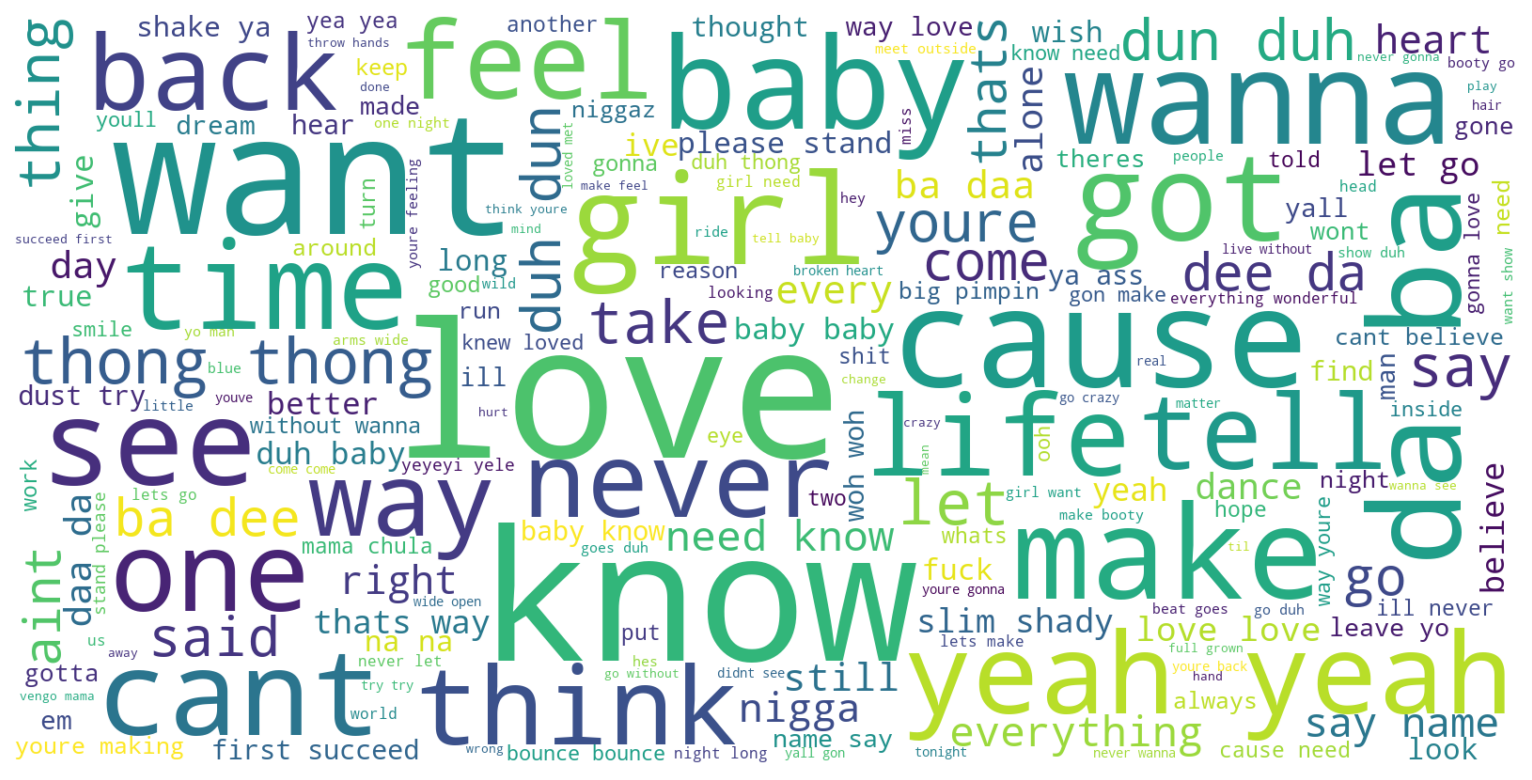

In [126]:
popular_words = pd.Series(lsc).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(popular_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
test2 = testdf2.filter(testdf2.Year.isin('2000'))
print(test2.select("All words").collect()[0])
print(type(test2.select("All words").collect()[0]))

In [ ]:
test3 = testdf3.filter(testdf2.Year.isin('2000'))
test3.show()

In [ ]:
sc.stop()